## Importing Libraries

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import activations
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Activation, Add, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Flatten, Input, Reshape, ZeroPadding2D
from tensorflow.keras.applications import ResNet101
from PIL import Image
import random

from google.colab import drive

## Initializing GPU Runtime

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Creating Required Layer Blocks

In [3]:
def dres_conv(x, s, filters):
    # here the input size changes
    x_skip = x
    f1, f2 = filters

    # third block
    x = Conv2DTranspose(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2DTranspose(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block
    x = Conv2DTranspose(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2DTranspose(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

In [4]:
def dres_identity(x, filters): 
    # resnet block where dimension doesnot change.
    # The skip connection is just simple identity conncection
    # There will be 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    # first block 
    x = Conv2DTranspose(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)


    # second block # bottleneck (but size kept same with padding)
    x = Conv2DTranspose(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2DTranspose(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

## Loading Data

In [5]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

170500096/170498071 [==============================] - 4s 0us/step
Shape of x_train: (50000, 32, 32, 3)
Shape of x_test: (10000, 32, 32, 3)


## Creating Encoder

In [6]:
input_im = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
Encoder = ResNet101(include_top=False, weights='imagenet', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x = Encoder(input_im)
x = Flatten()(x)
encoding = Dense(2048, kernel_initializer='he_normal')(x)
encoder = tf.keras.Model(inputs=input_im, outputs=encoding, name='Encoder')

171450368/171446536 [==============================] - 2s 0us/step


## Creating Decoder

In [7]:
# Decoder
dec_input = Input(shape=(2048,))
x = Dense(2 * 2 * 2048, kernel_initializer='he_normal')(dec_input)
x = Reshape((2, 2, 2048))(x)

x = dres_conv(x, s=2, filters=(512, 2048))
x = dres_identity(x, filters=(512, 2048))
x = dres_identity(x, filters=(512, 2048))

x = dres_conv(x, s=2, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))
x = dres_identity(x, filters=(256, 1024))


x = dres_conv(x, s=2, filters=(128, 512))
x = dres_identity(x, filters=(128, 512))
x = dres_identity(x, filters=(128, 512))
x = dres_identity(x, filters=(128, 512))

x = dres_conv(x, s=1, filters=(64, 256))
x = dres_identity(x, filters=(64, 256))
x = dres_identity(x, filters=(64, 256))
x = Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation(activations.sigmoid)(x)
decoder = tf.keras.Model(inputs=dec_input, outputs=decoded, name='Decoder')

## Creating Auto Encoder


In [8]:
enc_input = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
encoding = encoder(enc_input)
decoded = decoder(encoding)
auto_encoder = tf.keras.Model(inputs=enc_input, outputs=decoded, name='AutoEncoder')
# auto_encoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
auto_encoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Encoder (Model)              (None, 2048)              46854528  
_________________________________________________________________
Decoder (Model)              (None, 32, 32, 3)         118988815 
Total params: 165,843,343
Trainable params: 165,638,537
Non-trainable params: 204,806
_________________________________________________________________


## Loading Model Weights for Testing

In [9]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BPUnfY4cbkXbVELbROW8FurbiwLe8tWp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BPUnfY4cbkXbVELbROW8FurbiwLe8tWp" -O enc_weights.h5 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=15wWJF1XX4LkHwEgq59raO0zGCLxWftz-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=15wWJF1XX4LkHwEgq59raO0zGCLxWftz-" -O dec_weights.h5 && rm -rf /tmp/cookies.txt

--2020-07-30 10:55:49--  https://docs.google.com/uc?export=download&confirm=9r1K&id=1BPUnfY4cbkXbVELbROW8FurbiwLe8tWp
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.101, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-08-docs.googleusercontent.com/docs/securesc/0g8ojsej0843cnatlh77rr8s19uqpgf9/3s285soms63ophmph4b8biepqpllji8l/1596106500000/13034932157872882154/12427329847892378820Z/1BPUnfY4cbkXbVELbROW8FurbiwLe8tWp?e=download [following]
--2020-07-30 10:55:49--  https://doc-10-08-docs.googleusercontent.com/docs/securesc/0g8ojsej0843cnatlh77rr8s19uqpgf9/3s285soms63ophmph4b8biepqpllji8l/1596106500000/13034932157872882154/12427329847892378820Z/1BPUnfY4cbkXbVELbROW8FurbiwLe8tWp?e=download
Resolving doc-10-08-docs.googleusercontent.com (doc-10-08-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting

In [10]:
encoder.load_weights("enc_weights.h5")
decoder.load_weights("dec_weights.h5")

## Testing

In [11]:
X_test_embeddings = encoder(x_test)
n = random.randint(0, x_test.shape[0])
query = x_test[n]
query_embedding = encoder(np.expand_dims(query,0))
distances = {}
for i,x in enumerate(X_test_embeddings):
    temp = tf.norm(x - query_embedding, ord = 'euclidean').numpy()
    distances[temp] = i
keys = sorted(distances.keys())[:10]
inds = [distances[i] for i in keys]
embeddings = [X_test_embeddings[ind] for ind in inds]
embeddings = np.array(embeddings)
images = decoder(embeddings)

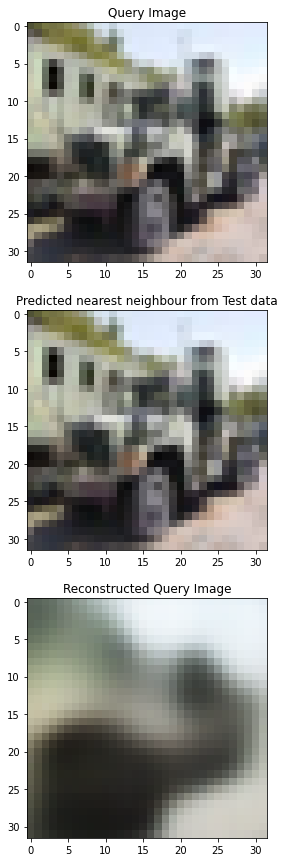

In [12]:
fig, axs = plt.subplots(3,1, figsize=(15,15))
axs[0].imshow(query)
axs[0].set_title('Query Image')
axs[1].imshow(x_test[inds[0]])
axs[1].set_title('Predicted nearest neighbour from Test data')
axs[2].imshow(images[0])
axs[2].set_title('Reconstructed Query Image')
plt.show()

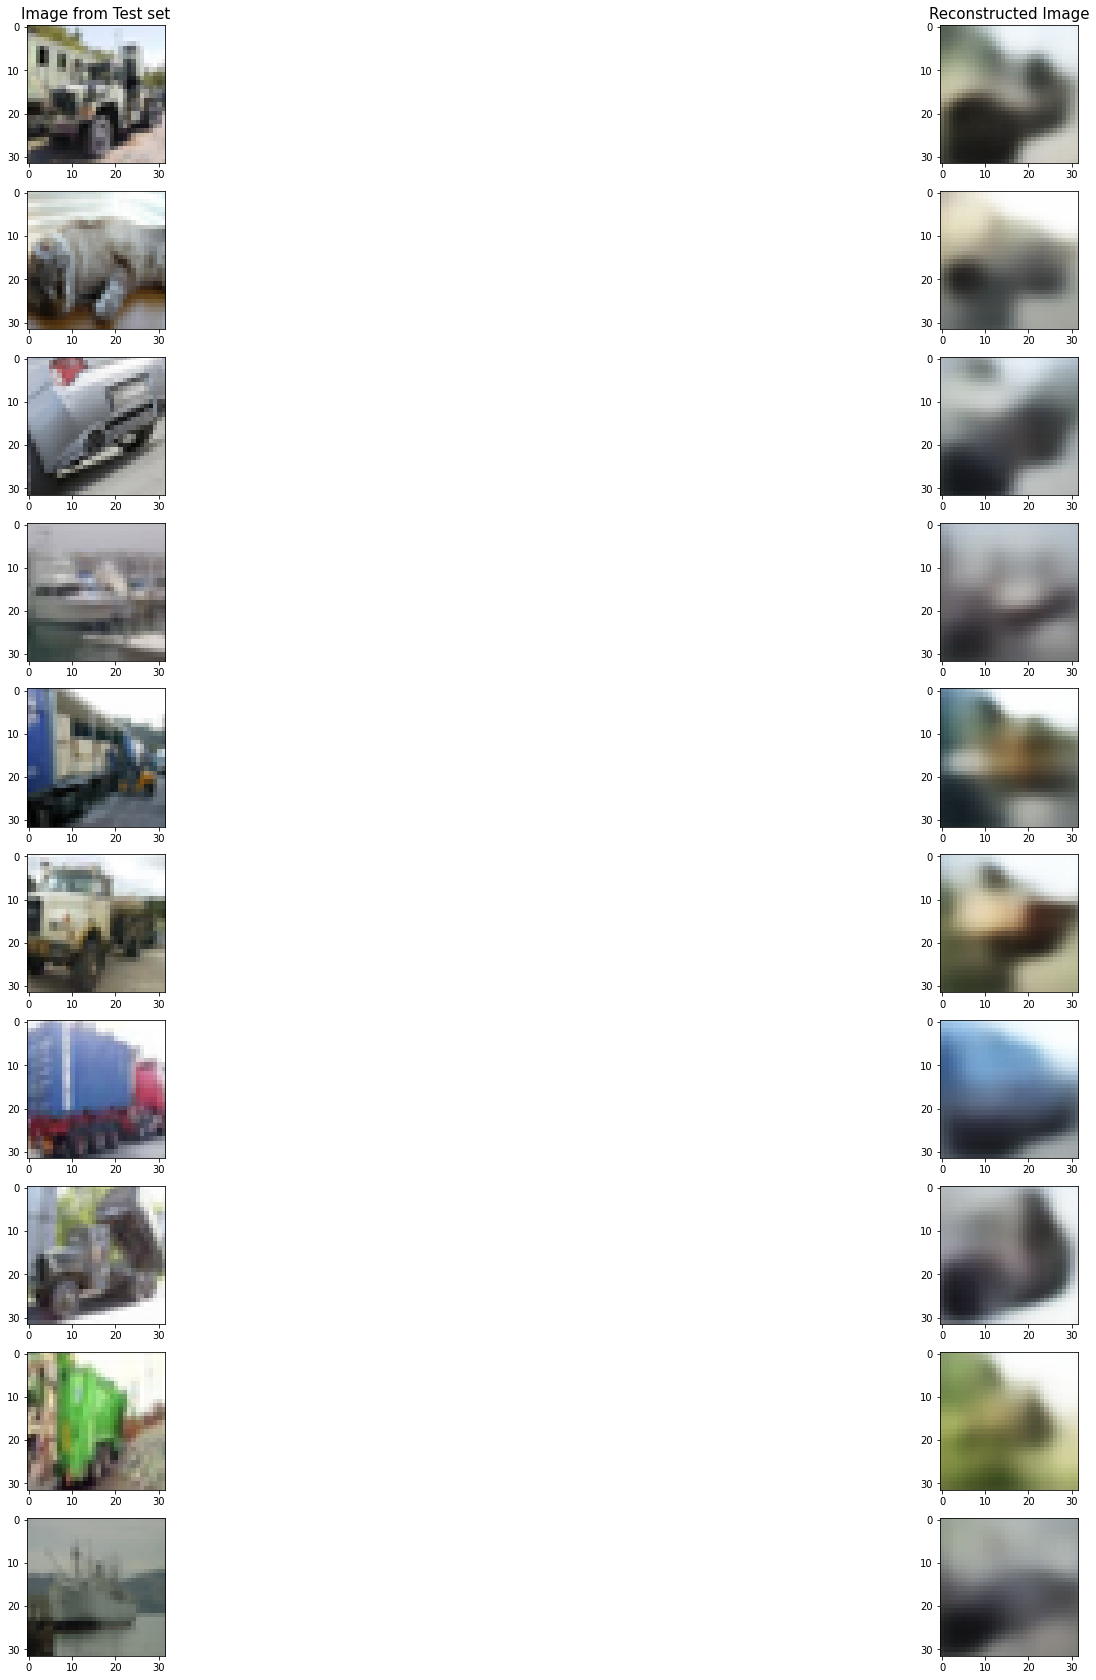

In [13]:
fig, axs = plt.subplots(10, 2, figsize=(30,30))
axs[0,0].imshow(x_test[inds[0]])
axs[0,0].set_title('Image from Test set', fontsize=15)
axs[0,1].imshow(images[0])
axs[0,1].set_title('Reconstructed Image', fontsize=15)
axs[0,0].imshow(x_test[inds[0]])
for i in range(1,10):
    axs[i,0].imshow(x_test[inds[i]])
    axs[i,1].imshow(images[i])